In [55]:
from nilearn.glm.first_level import FirstLevelModel
from nilearn import image
import pandas as pd
import numpy as np
import os
import csv
import matplotlib.pyplot as plt
from nilearn.plotting import plot_design_matrix
from pathlib import Path

In [56]:
cwd = os.getcwd()

path = cwd +  '/../fMRI_Data/sub-001/func/sub-001_task-Training_run-01_bold.nii'

fmri_img = image.load_img(path)

events_path = cwd + '/../fMRI_Data/sub-001/func/sub-001_task-Training_run-01_events.tsv'
events_path2 = cwd + '/../fMRI_Data/sub-001/func/sub-001_task-Training_run-02_events.tsv'

events = pd.read_csv(events_path, sep='\t', usecols=[0, 1, 2])

# path2 = cwd + '/../fMRI_Data/sub-001/func/sub-001_task-Training_run-02_bold.nii'
# fmri_img2 = image.load_img(path2)
# fmri_img = image.concat_imgs([fmri_img, fmri_img2])
# events_path2 = cwd + '/../fMRI_Data/sub-001/func/sub-001_task-Training_run-02_events.tsv'
# events2 = pd.read_csv(events_path2, sep='\t', usecols=[0, 1, 2])
# events2.iloc[:, 0] += 615
# events2.index += 41
# events = pd.concat([events, events2])

events.rename(columns={events.columns[2]: 'trial_type'}, inplace=True)
events['trial_type'] = events['trial_type'].str.strip("'") # remove single quotes from trial_type column

# Account for 2s fade in and 2s fade out
events['duration'] = events['duration'] - 4
events['onset'] = events['onset'] + 2


print(events.tail(50))
print(events.shape)





    onset  duration trial_type
0       2        11      disco
1      17        11      blues
2      32        11     hiphop
3      47        11        pop
4      62        11       jazz
5      77        11  classical
6      92        11      disco
7     107        11    country
8     122        11      metal
9     137        11     reggae
10    152        11       rock
11    167        11      blues
12    182        11       jazz
13    197        11       rock
14    212        11  classical
15    227        11     reggae
16    242        11    country
17    257        11     hiphop
18    272        11        pop
19    287        11      metal
20    302        11      disco
21    317        11      blues
22    332        11       rock
23    347        11  classical
24    362        11      disco
25    377        11     hiphop
26    392        11     reggae
27    407        11        pop
28    422        11      metal
29    437        11       jazz
30    452        11    country
31    46

In [57]:
fmri_glm = FirstLevelModel(
    t_r=1.5,
    noise_model="ar1",
    standardize=False,
    hrf_model="spm",
    drift_model="cosine",
    high_pass=0.01,
)

fmri_glm = fmri_glm.fit(fmri_img, events)


In [58]:
design_matrix = fmri_glm.design_matrices_[0]
print(design_matrix.sum(axis=0))



blues        2.936017e+01
classical    2.936017e+01
country      2.936017e+01
disco        3.670021e+01
hiphop       2.955303e+01
jazz         2.936017e+01
metal        2.698779e+01
pop          2.936017e+01
reggae       2.936017e+01
rock         2.936017e+01
drift_1      8.049117e-16
drift_2     -8.049117e-16
drift_3      2.095546e-15
drift_4     -7.494005e-16
drift_5      1.137979e-15
drift_6     -2.567391e-15
drift_7      2.053913e-15
drift_8     -2.331468e-15
drift_9      6.938894e-16
drift_10    -1.429412e-15
drift_11     1.124101e-15
drift_12    -2.484124e-15
constant     4.100000e+02
dtype: float64


In [59]:
print(events['trial_type'].unique())

['disco' 'blues' 'hiphop' 'pop' 'jazz' 'classical' 'country' 'metal'
 'reggae' 'rock']


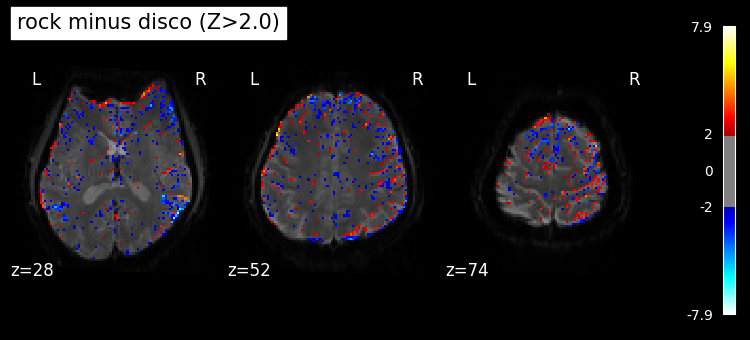

In [60]:
from nilearn.plotting import plot_stat_map, plot_contrast_matrix
contrast_matrix = np.eye(design_matrix.shape[1])
basic_contrasts = dict([(column, contrast_matrix[i])
                        for i, column in enumerate(design_matrix.columns)])

# Specify your contrast; for example, comparing condition 'A' vs 'B'
cond_a, cond_b = 'rock', 'disco'
contrast_def = basic_contrasts['rock'] - basic_contrasts['disco']

# Compute the contrast
z_map = fmri_glm.compute_contrast(contrast_def, output_type='z_score')
# eff_map = fmri_glm.compute_contrast(contrast_def, output_type='effect_size')
mean_img = image.mean_img(fmri_img)
# plot_stat_map(z_map, threshold=0.8, display_mode='z', cut_coords=3, title='Condition A vs B')
# plot_contrast_matrix(contrast_def, design_matrix=design_matrix)
threshold = 2.0
plot_stat_map(
    z_map,
    bg_img=mean_img,
    threshold=threshold,
    display_mode="z",
    cut_coords=3,
    black_bg=True,
    title=f"{cond_a} minus {cond_b} (Z>{threshold})"
)
plt.show()


Uncorrected p<0.001 threshold: 3.291


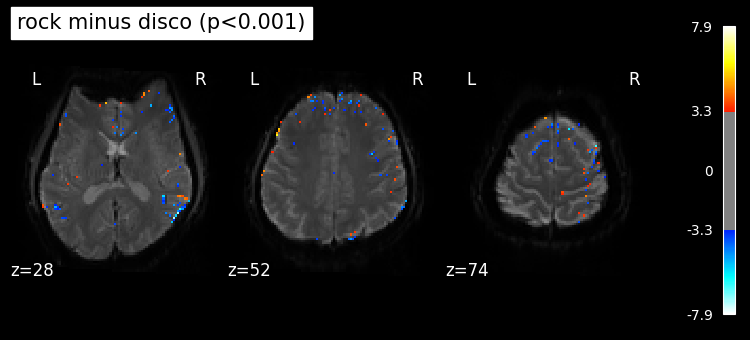

In [61]:
from nilearn.glm import threshold_stats_img
alpha = 0.001
_, threshold = threshold_stats_img(z_map, alpha=alpha, height_control="fpr")
print(f"Uncorrected p<{alpha} threshold: {threshold:.3f}")
plot_stat_map(
    z_map,
    bg_img=mean_img,
    threshold=threshold,
    display_mode="z",
    cut_coords=3,
    black_bg=True,
    title=f"{cond_a} minus {cond_b} (p<{alpha})",
)
plt.show()

Bonferroni-corrected, p<0.05 threshold: 4.563


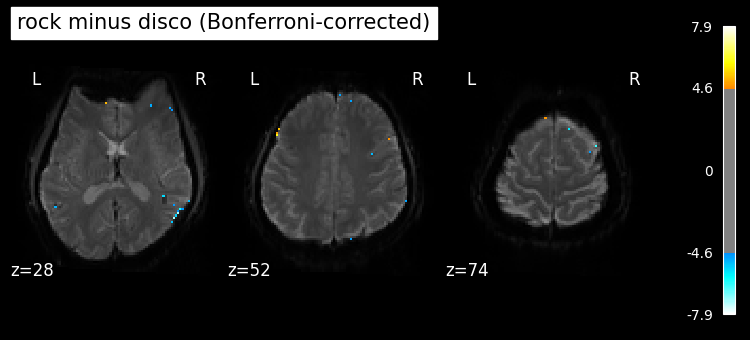

In [62]:
_, threshold = threshold_stats_img(
    z_map, alpha=0.9, height_control="bonferroni"
)
print(f"Bonferroni-corrected, p<0.05 threshold: {threshold:.3f}")
plot_stat_map(
    z_map,
    bg_img=mean_img,
    threshold=threshold,
    display_mode="z",
    cut_coords=3,
    black_bg=True,
    title=f"{cond_a} minus {cond_b} (Bonferroni-corrected)",
)
plt.show()

False Discovery rate = 0.05 threshold: 3.128


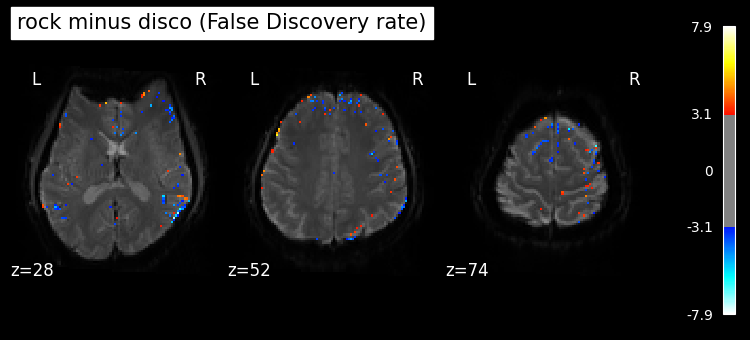

In [63]:
_, threshold = threshold_stats_img(z_map, alpha=0.05, height_control="fdr")
print(f"False Discovery rate = 0.05 threshold: {threshold:.3f}")
plot_stat_map(
    z_map,
    bg_img=mean_img,
    threshold=threshold,
    display_mode="z",
    cut_coords=3,
    black_bg=True,
    title=f"{cond_a} minus {cond_b} (False Discovery rate)",
)
plt.show()

Output will be saved to: c:\EiT\EiT-Group5\AnalysisMethods\results\plot_single_subject_single_run
Design matrix has shape 410 rows and 23 columns
First few columns are Index(['blues', 'classical', 'country', 'disco', 'hiphop'], dtype='object')


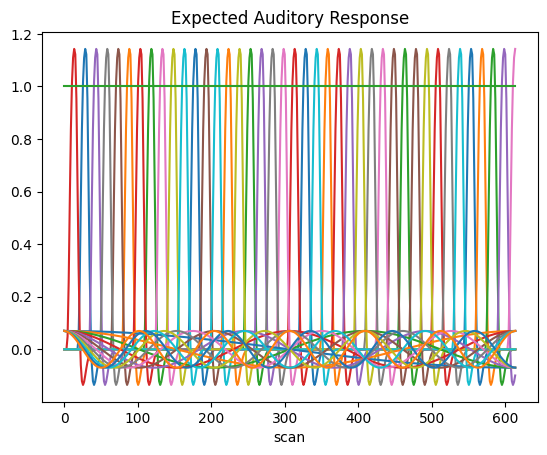

In [64]:
# plot_design_matrix(design_matrix)

output_dir = Path.cwd() / "results" / "plot_single_subject_single_run"
output_dir.mkdir(exist_ok=True, parents=True)
print(f"Output will be saved to: {output_dir}")

plot_design_matrix(design_matrix, output_file=output_dir / "design_matrix.png")

print(f"Design matrix has shape {design_matrix.shape[0]} rows and {design_matrix.shape[1]} columns")
print(f"First few columns are {design_matrix.columns[:5]}")
plt.plot(design_matrix)
plt.xlabel("scan")
plt.title("Expected Auditory Response")
plt.show()

# condition_names = events["trial_type"].unique()
# conditions = {}
# for i, condition in enumerate(condition_names):
#     conditions[condition] = np.zeros(design_matrix.shape[0])
#     conditions[condition][i] = 1
# print(conditions)